# <center>Abssenteísmo no trabalho</center>
___

### 1.0 Importar bibliotecas

In [1]:
#importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
import pickle
import avaliar_modelo as pod
import warnings
warnings.filterwarnings('ignore')

### 2.0 Importar base

In [2]:
df_01 = pd.read_excel('C:\\Users\\leticia\\Desktop\\Abssenteismo\\Absenteeism_at_work.xls')
df_01.shape

(740, 21)

In [3]:
df_01.head()

,ID,Motivo,Mês,Dia_da_Semana,Temporadas,Despesa_Trasporte,Distancia_ao_Trabalho,Tempo_de _servico,Idade,Carga_horaria_media_por_dia,...,Falha_disciplinar,Escolaridade,Filho,Bebedor_social,Fumante_social,Animal_de_estimacao,Peso,Altura,IMC,Tempo_de_absenteIsmo_em_horas
0,11,26,7,3,1,289,36,13,33,239554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239554,...,0,1,2,1,0,1,90,172,30,2


In [4]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   ID                             740 non-null    int64
 1   Motivo                         740 non-null    int64
 2   Mês                            740 non-null    int64
 3   Dia_da_Semana                  740 non-null    int64
 4   Temporadas                     740 non-null    int64
 5   Despesa_Trasporte              740 non-null    int64
 6   Distancia_ao_Trabalho          740 non-null    int64
 7   Tempo_de _servico              740 non-null    int64
 8   Idade                          740 non-null    int64
 9   Carga_horaria_media_por_dia    740 non-null    int64
 10  Meta_atingida                  740 non-null    int64
 11  Falha_disciplinar              740 non-null    int64
 12  Escolaridade                   740 non-null    int64
 13  Filho               

### 3.0 Construindo o target

In [5]:
q1 = df_01.Tempo_de_absenteIsmo_em_horas.quantile(0.25)
q3 = df_01.Tempo_de_absenteIsmo_em_horas.quantile(0.75)
iqr = q3 - q1
outlier = q1 + 1.5 * (q3 - q1)

In [6]:
q1, q3, iqr, outlier

(2.0, 8.0, 6.0, 11.0)

In [7]:
df_01['Target'] = [1 if i >= outlier else 0 for i in df_01.Tempo_de_absenteIsmo_em_horas]

### 4.0 Separando dados para garantir validação cruzada Holdout 70/30

In [8]:
# Separando as variáveis de entrada (features) e de saída (target)
X = df_01.drop(columns=['ID', 'Motivo','Tempo_de_absenteIsmo_em_horas','Target'])
y = df_01["Target"]

In [9]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((518, 18), (222, 18))

### 5.0 Feature Selection

In [10]:
# Treinar modelo com algoritmo Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Número de features selecionadas:  4


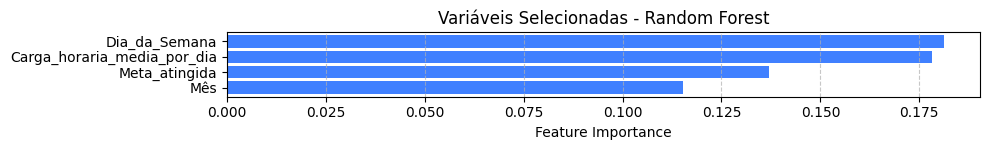

In [11]:
# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximo = 0.5

cutoff = cutoff_maximo * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ',len(selected_features))

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 6.0 Modelo final

In [12]:
# Separando as variáveis de entrada (features) e de saída (target)
X = df_01[selected_features_df['Feature'].tolist()]
y = df_01["Target"]

In [13]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((518, 4), (222, 4))

In [14]:
# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# penalty='l2', # Tipo de regularização: 'l1', 'l2', 'elasticnet', 'none'
# dual=False, # Formulação primal e dual do problema de otimização da regressão logística, sendo recomendado manter como False quando temos mais amostras do que Variáveis
# tol=0.0001, # Tolerância para critério de parada.
# C=1.0, # Inverso da força de regularização; deve ser um valor flutuante positivo. Como valores menores, especifica uma regularização mais forte.
# fit_intercept=True, # Especifica se uma constante (ou seja, viés ou interceptação) deve ser adicionada à função de decisão.
# intercept_scaling=1, # Útil apenas quando o solver 'liblinear' é usado e self.fit_intercept é definido como True.
# class_weight=None, # Pesos associados às classes. Se não for fornecido, todas as classes são supostas ter peso um.
# random_state=None, # Semente usada pelo gerador de números aleatórios.
# solver='lbfgs', # Algoritmo a ser usado no problema de otimização: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, padrão='lbfgs'
# max_iter=100, # Número máximo de iterações para os solvers convergirem.
# multi_class='auto', # Se a opção escolhida for 'ovr', então um problema binário é ajustado para cada rótulo. Para 'multinomial', a perda minimizada é a perda multinomial ajustando todo o conjunto de dados de uma vez.
# verbose=0, # Para o solver 'liblinear' e 'lbfgs', defina o valor para qualquer inteiro positivo para classificar a verbosidade.
# warm_start=False, # Quando definido como True, reutiliza a solução da chamada anterior para ajustar como inicialização, caso contrário, apenas apaga a solução anterior.
# l1_ratio=None # O valor de Elastic-Net mixing parameter, com 0 <= l1_ratio <= 1. Somente usado se penalty='elasticnet'.


# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}


# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rl = grid.best_estimator_

Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.6283905686201318
Gini normalizado -->  0.54


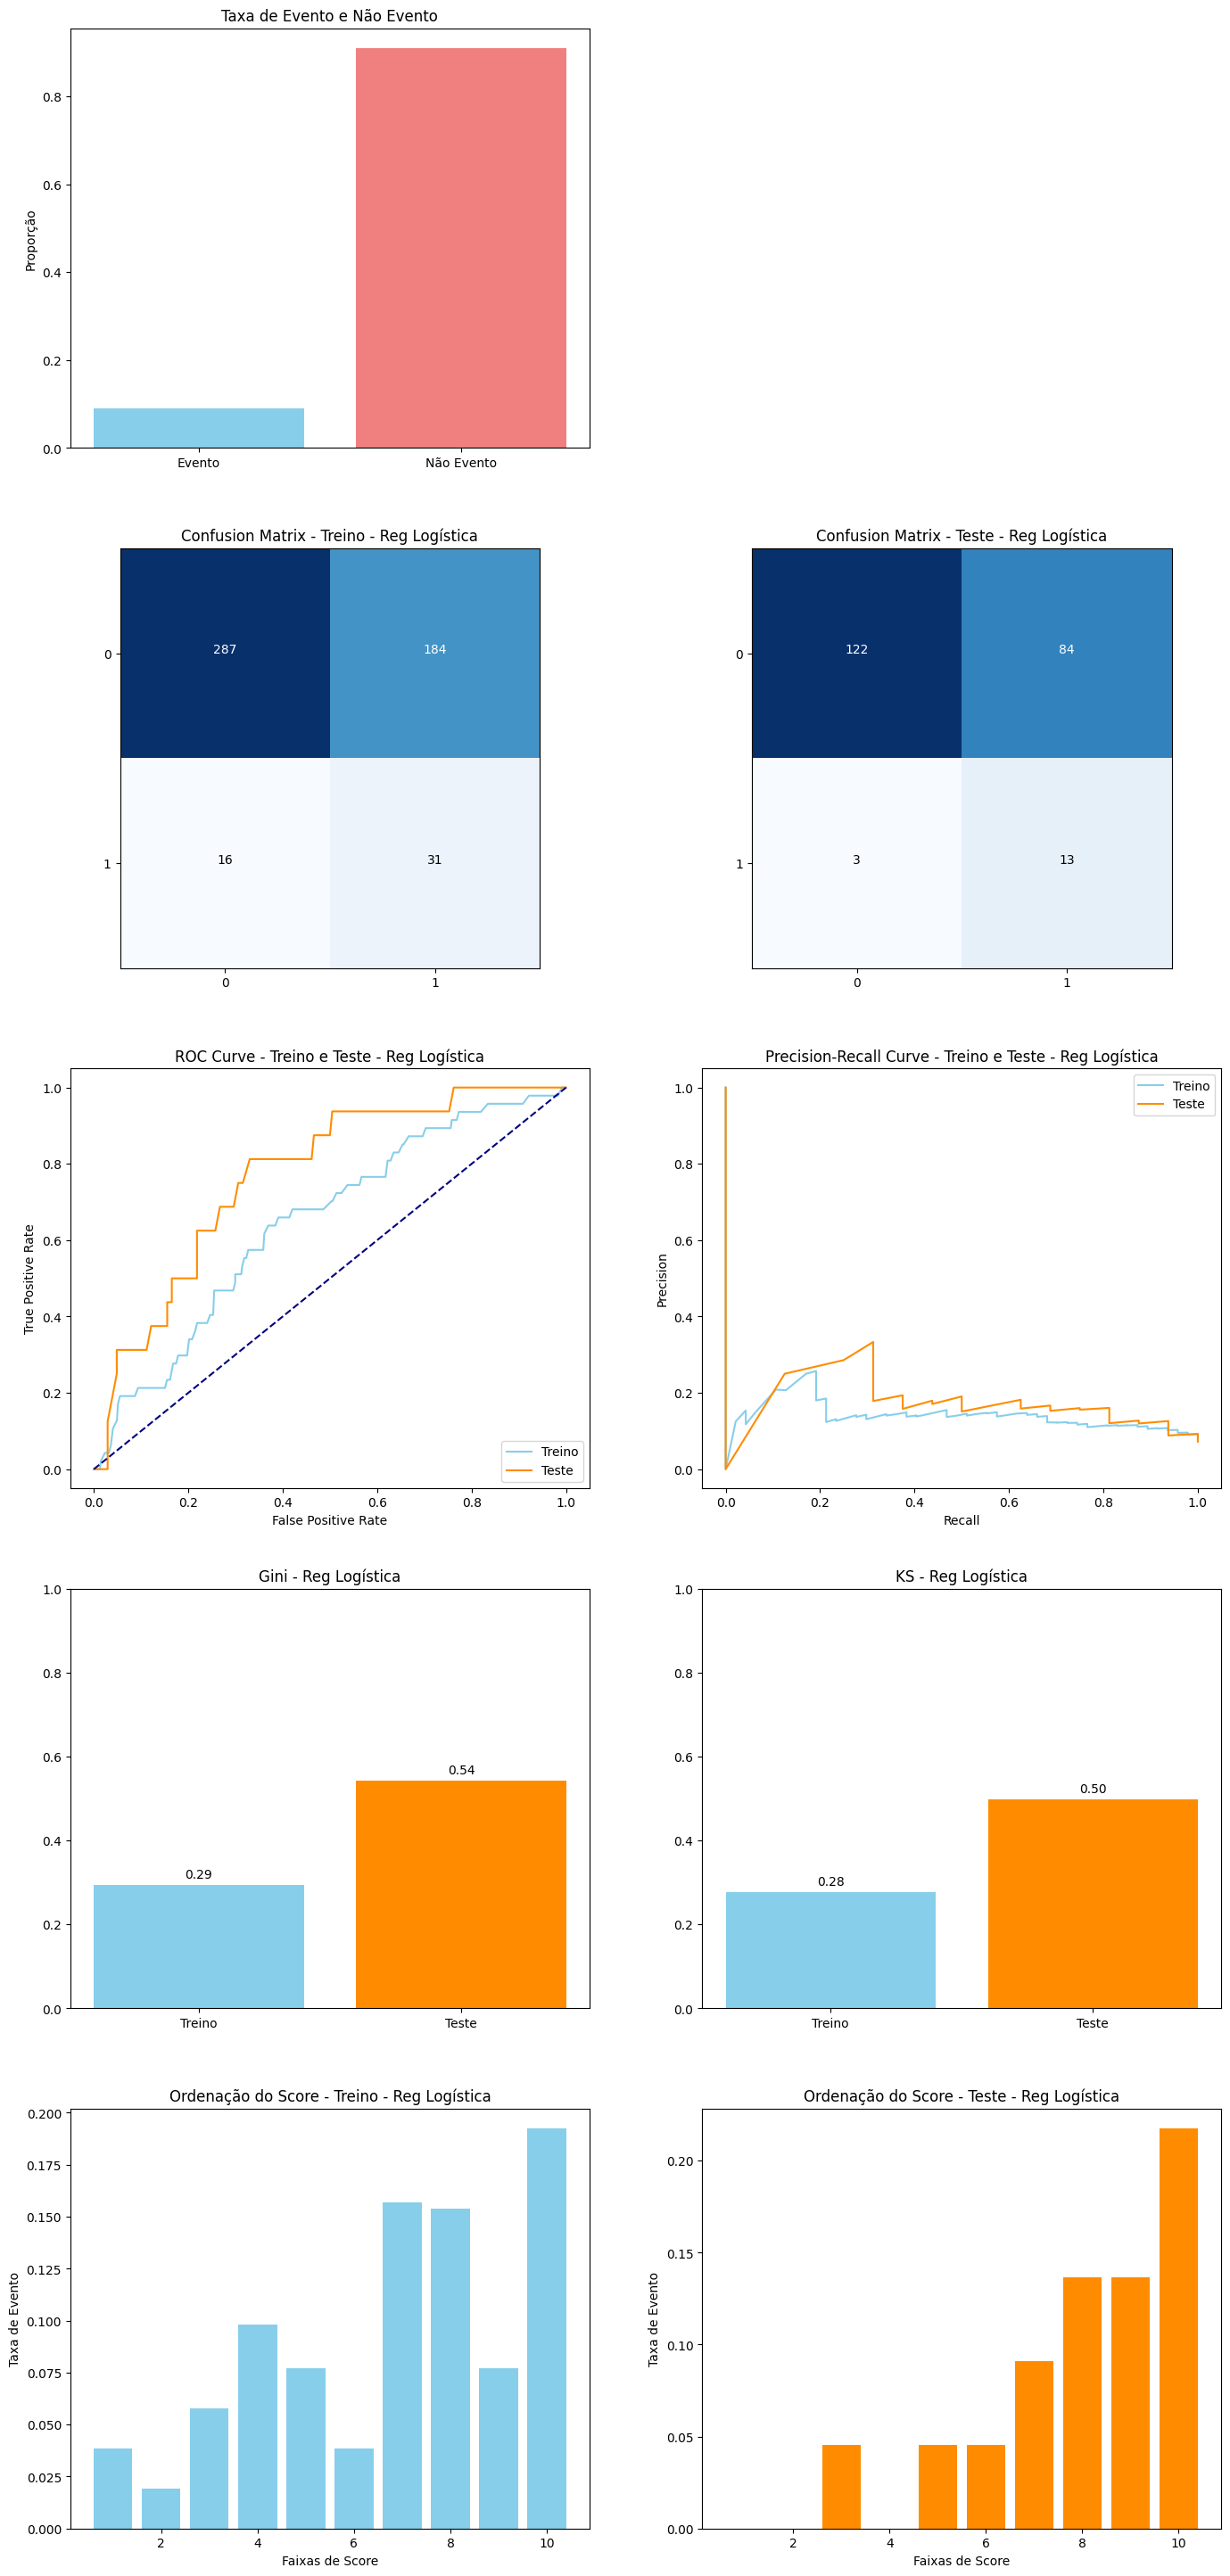

In [15]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, grid, nm_modelo='Reg Logística')

### 7.0 Salvando artefatos dos modelos

In [ ]:
with open('modelo/best_model_rl.pkl', 'wb') as file:
  pickle.dump(best_model_rl, file)